In [10]:
import numpy as np
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn import svm
import xgboost as xgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.ensemble import VotingRegressor, VotingClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [11]:
def load_data(y):
    path = '../../data/std_data/'
    x_train_std = pd.read_pickle(path +'train/{}_x.pkl'.format(str(y))).values
    x_test_std = pd.read_pickle(path +'test/{}_x.pkl'.format(str(y))).values
    y_train = pd.read_pickle(path +'train/{}_y.pkl'.format(str(y))).values
    y_test = pd.read_pickle(path +'test/{}_y.pkl'.format(str(y))).values
    features = pd.read_pickle(path +'train/{}_x.pkl'.format(str(y))).columns
    return x_train_std, x_test_std, y_train, y_test, features

In [12]:
def plot_roc_curve(fpr, tpr, auc):
    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

In [13]:
def create_models():
    lr = LogisticRegression(class_weight="balanced", solver="liblinear",  penalty="l2", C=0.0001)
    
    sv = svm.SVR(kernel="sigmoid",
                                 degree=4,
                                 gamma=0.043502212815589775,
                                 coef0=0.20190829020616494,
                                 tol=0.0001,
                                 C=0.000245786293391316,
                                 epsilon=0.3056167642389302,
                                verbose=True,)

    xgboost = xgb.XGBRegressor(silent= True, 
                           max_depth=1,
                           learning_rate=0.14544434403253392,
                           n_estimators = 72,
                           gamma=0.4356018082020117,
                           reg_lambda=2.931451663505623,
                           reg_alpha=0.19045302677956732)

    lgbm = lgb.LGBMRegressor(
        random_state=0,
        verbosity=-1,
        bagging_seed=0,
        boost_from_average='true',
        metric='auc',
        bagging_freq=4,
        min_data_in_leaf=21,
        max_depth=13,
        learning_rate=0.08731913651405197,
        n_estimators=3394,
        subsample=0.7054763057027115,
        num_leaves=438,
        reg_lambda=0.9377125325944119,  
    )
    
    lda = LDA(solver="eigen", shrinkage=1)

#     estimators_rgs = [('sv', sv), ('xgboost', xgboost), ('lgbm', lgbm)]
    estimators_rgs = [('sv', sv),('lgbm', lgbm)]
    
    return estimators_rgs

In [14]:
def main():
    
    
    path = '../../data/dataframes/std_data/'
#     df =  pd.read_pickle('../../data/dataframes/unificated_data_set.pkl')
    
    cm_all = np.zeros((2, 2))
    
    # 予測した確率全体を格納
    probs_all = np.array([])
    y_true_all = np.array([])
    
    for y in range(1978, 2020):
        
        # データの生成
        x_train, x_test, y_train, y_test, features = load_data(y)
       
        # 学習
        estimators= create_models()
        
        vr = VotingRegressor(estimators)

        vr.fit(x_train, y_train)
        
        # 予測(確率)
        probs = vr.predict(x_test)
        probs_all = np.hstack((probs_all, probs))
        y_true_all = np.hstack((y_true_all, y_test))
        
        print(probs)

        # 混同行列
        y_pred = np.where((probs ==  max(probs)), 1, 0) #確率→0/1
        cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
        cm_all += cm
    
    auc = roc_auc_score(y_true_all, probs_all)
    fpr, tpr, thresholds = roc_curve(y_true_all, probs_all)
    
    plot_roc_curve(fpr, tpr, auc)
    
    print("len: {0} , {1}".format(len(y_true_all), len(probs_all) ))
    print("confusion_matrix: ")
    print(cm_all)
    print("AUC: ")
    print(auc)
    print()
    return

[LibSVM][0.3216326  0.2134469  0.12689554 0.21332683 0.10513933]
[LibSVM][0.46109286 0.16320013 0.23365305 0.24153291 0.21025618]
[LibSVM][0.30941768 0.32653568 0.23333651 0.31757456 0.15630694]
[LibSVM][0.05863577 0.14909542 0.15381485 0.15376956 0.34540711]
[LibSVM][0.49423129 0.32842449 0.38458258 0.34614613 0.17554195]
[LibSVM][0.38084406 0.14629292 0.17848126 0.15260859 0.16768978]
[LibSVM][0.16251432 0.23863813 0.21989915 0.24367403 0.20330976]
[LibSVM][0.25741283 0.26238433 0.45164889 0.18147071 0.06299576]
[LibSVM][0.17057834 0.17186352 0.18535158 0.36309534 0.56187991]
[LibSVM][0.25498473 0.16565442 0.13026268 0.11839156 0.37577299]
[LibSVM][0.48443075 0.1446556  0.17523783 0.28532315 0.19011076]
[LibSVM][0.17713172 0.30194203 0.0902137  0.23100298 0.1741303 ]
[LibSVM][0.53155719 0.17372883 0.24568116 0.31763286 0.116716  ]
[LibSVM][0.41366739 0.22536233 0.24631953 0.11609648 0.23043309]
[LibSVM][0.74380246 0.32568682 0.28105597 0.28495859 0.1744172 ]
[LibSVM][0.56549665 0.285

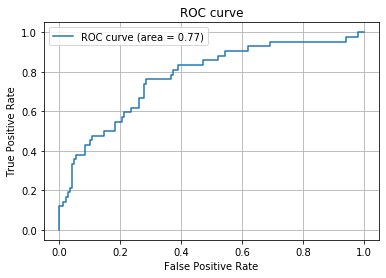

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC: 
0.7738799661876584



In [15]:
main()